## Project Description

- **Goal:** Predict 15-minute *change* (delta) in ATM implied volatility using sequence models.

- **Data:** ~5,033,411, agg to ~35k,  11 features, 16-step time window per input sequence.

- **Model (tuned):** LSTM selected (2 layers, hidden size 124) based on validation performance.

- **Performance:** RMSE improved from **8.98 → 8.34** (~**7.1%** better than baseline).

- **Directionality:** **63.5%** directional accuracy (better than 50% random).

- **Meaning:** The model learns short-term, non-linear patterns in IV changes beyond persistence.

- **Slide takeaway:** Sequence learning adds measurable predictive value at a 15-minute horizon.



### Why This Model Is Useful
- Traders can use this to forecast if IV would be higher or lower to determine entry times.
- Market makers can use the forecast to adjust quote widths and inventory hedging ahead of short-horizon volatility regime shifts.
- Risk teams can use the predicted IV change as a short-term signal to update intraday VaR/stress assumptions and position limits.

### RNN(LSTM) and CNN Feature Input
- `ATM_IV` — average implied volatility for near-ATM options (moneyness 0.98–1.02, else overall mean).
- `Skew` — put IV minus call IV (proxy for downside vs upside IV asymmetry).
- `Term_Structure` — far-dated IV (>10d) divided by near-dated IV (<=10d) to capture maturity slope.
- `Realized_Vol` — trailing realized volatility from past returns (shifted, rolling std over 4 × 15-min bars).
- `Volume` — total option trade amount summed within the 15-minute bucket.
- `ATM_IV_Change` — first difference of ATM_IV (current minus previous 15-min ATM_IV).
- `ATM_IV_Change_Lag1` — one-period lag of ATM_IV_Change (previous delta of ATM_IV).
- `tod_sin` — time-of-day encoded as sine (cyclical 24-hour pattern).
- `tod_cos` — time-of-day encoded as cosine (cyclical 24-hour pattern).
- `dow_sin` — day-of-week encoded as sine (cyclical 7-day pattern).
- `dow_cos` — day-of-week encoded as cosine (cyclical 7-day pattern).


### Configuration Params
- TIME_WINDOW = '15min'
- N_TRIALS = 20
- SEQ_LEN = 16                 # CNN looks at last SEQ_LEN bars of features
- DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
- SEED = 11


### Other Params
**Hyperparameters searched (RNN / `objective_rnn`)**
- `rnn_type` : {"GRU", "LSTM"} = optimal : LSTM
- `hidden_size` : [16, 128] (int) = optimal : 124
- `num_layers` : [1, 3] (int) = optimal : 2
- `dropout` : [0.0, 0.4] (float) = optimal : 0.08970216565433058
- `lr` : [1e-4, 5e-3] (float, log) = optimal : 0.00044078917629833576
- `weight_decay` : [1e-8, 1e-2] (float, log) = optimal : 0.006949732456304038
- `batch_size` : {64, 128, 256} = optimal : 256

**Hyperparameters searched (CNN / `objective_cnn`)**
- `channels` : [16, 128] (int) = optimal : 48
- `kernel_size` : {3, 5, 7} = optimal : 7
- `dropout` : [0.0, 0.4] (float) = optimal : 0.3051715051170321
- `lr` : [1e-4, 5e-3] (float, log) = optimal : 0.0009867502969472112
- `weight_decay` : [1e-8, 1e-2] (float, log) = optimal : 0.0052445339345040315
- `batch_size` : {64, 128, 256} = optimal : 256

**Hyperparameters NOT in the Optuna search (in this code)**
- `SEQ_LEN` (fixed at 16)
- `MAX_EPOCHS` (fixed at 30)
- `PATIENCE` (fixed at 10)
- `VAL_FRAC` (fixed at 0.10) — separate from the CV inside Optuna
- `n_splits` in `TimeSeriesSplit` (fixed at 3)
- Optimizer choice (always `Adam`)
- Loss function (always `MSELoss`)
- CNN architecture depth / number of conv layers (fixed at 2 conv layers)
- Activation function (fixed `ReLU`)
- Pooling type (fixed `AdaptiveAvgPool1d(1)`)
- Whether data is scaled (always `StandardScaler` fit on train split)
- `shuffle` in DataLoader (always `False`)
- Random seed / determinism settings (fixed via `RANDOM_SEED`)


### RNN : This is an LSTM-based Recurrent Neural Network
- We evaluated both GRU and LSTM variants within the RNN family, and the LSTM configuration achieved the best validation performance.


### CNN : This is a 1D Convolutional Neural Network over time
- Convolutional filters slide across the 15-minute time axis to extract local IV change patterns before pooling and prediction.
- Pooling : After the convolution layers extract patterns across the 16 time steps of 15 mins, the model averages each learned temporal pattern across the entire time window.

### Baseline Model :
- **Baseline used in this code:** “Zero-change” (no-move) predictor.
- **Prediction rule:**  ŷ_t = 0   for all t
- The model assumes the next 15-min IV change is **zero** every time.
- **Where it appears:** `naive_rmse = rmse_np(y_test, np.zeros_like(y_test))`
For many short horizons, the mean change is near 0, so “predict 0” is a legitimate no-skill / no-trade reference point.

In [1]:
import pandas as pd
FILE_PATH   = "../../data/derivative_data_2025.parquet"
df = pd.read_parquet(FILE_PATH)
df

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,contracts,amount,combo_trade_id,combo_id,block_trade_leg_count,block_trade_id,block_rfq_id,liquidation,date_time
0,739,406685410,1767308353475,0,0.0016,0.001524,27.82,BTC-2JAN26-89000-C,88564.81,buy,2.0,2.0,None,None,NaN,None,NaN,None,2026-01-01 22:59:13.475
1,37,406685409,1767308352194,3,0.0105,0.010682,32.09,BTC-3JAN26-89000-P,88567.92,buy,0.3,0.3,None,None,NaN,None,NaN,None,2026-01-01 22:59:12.194
2,702,406685408,1767308351483,1,0.0003,0.000213,62.38,BTC-27MAR26-210000-C,88567.92,buy,0.1,0.1,None,None,NaN,None,NaN,None,2026-01-01 22:59:11.483
3,36,406685394,1767308350210,3,0.0105,0.010683,32.07,BTC-3JAN26-89000-P,88571.73,buy,0.2,0.2,None,None,NaN,None,NaN,None,2026-01-01 22:59:10.210
4,6474,406685371,1767308342819,2,0.0565,0.056423,42.50,BTC-27MAR26-85000-P,88577.32,sell,0.1,0.1,None,None,NaN,None,NaN,None,2026-01-01 22:59:02.819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307605,707,338106877,1735686088094,0,0.0775,0.076877,58.34,BTC-31JAN25-96000-P,93266.66,buy,1.5,1.5,None,None,NaN,None,NaN,None,2024-12-31 23:01:28.094
5307606,212,338106873,1735686068471,2,0.0120,0.012547,56.86,BTC-17JAN25-105000-C,93261.73,sell,0.3,0.3,None,None,NaN,None,NaN,None,2024-12-31 23:01:08.471
5307607,59,338106865,1735686056749,1,0.0100,0.010025,48.35,BTC-2JAN25-93000-P,93267.62,sell,0.1,0.1,None,None,NaN,None,NaN,None,2024-12-31 23:00:56.749
5307608,59,338106861,1735686042786,0,0.0155,0.015522,48.22,BTC-2JAN25-94000-P,93284.96,buy,0.1,0.1,None,None,NaN,None,NaN,None,2024-12-31 23:00:42.786


>>> Loading Parquet Data...
>>> Resampling to 15min bars...
>>> Creating Delta Target...
Data Prepared (tabular). Rows: 35130 | Features: 11
NN Sequences: X=(35115, 16, 11), y=(35115,)
NN Split: train=25283, val=2809, test=7023

>>> Tuning RNN Hyperparameters...


Best RNN Params: {'rnn_type': 'LSTM', 'hidden_size': 124, 'num_layers': 2, 'dropout': 0.08970216565433058, 'lr': 0.00044078917629833576, 'weight_decay': 0.006949732456304038, 'batch_size': 256}

>>> Tuning CNN Hyperparameters...


Best CNN Params: {'channels': 48, 'kernel_size': 7, 'dropout': 0.3051715051170321, 'lr': 0.0009867502969472112, 'weight_decay': 0.0052445339345040315, 'batch_size': 256}

>>> Training Final RNN...



=== RNN RESULTS ===
Model RMSE:   8.343048
Baseline RMSE:8.980982
Improvement:  7.10%
Directional Accuracy: 63.54%


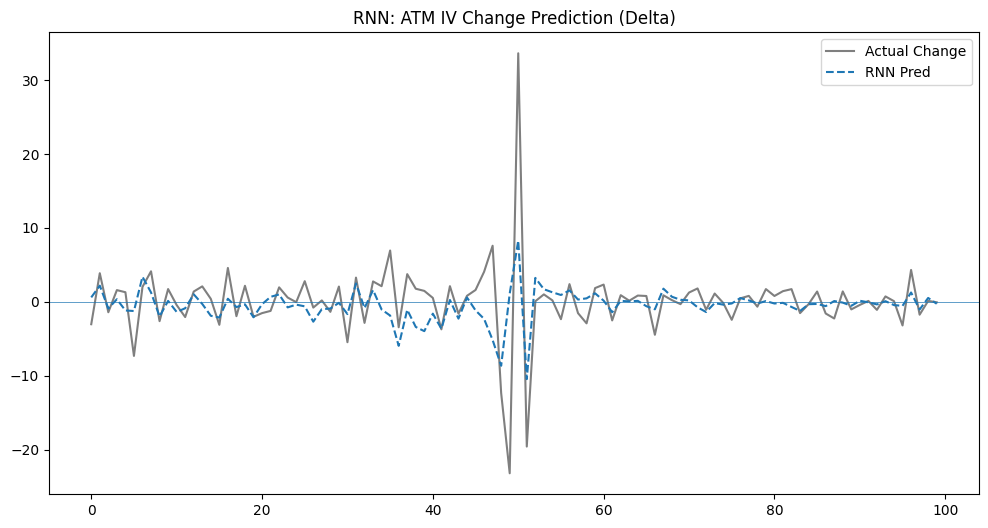

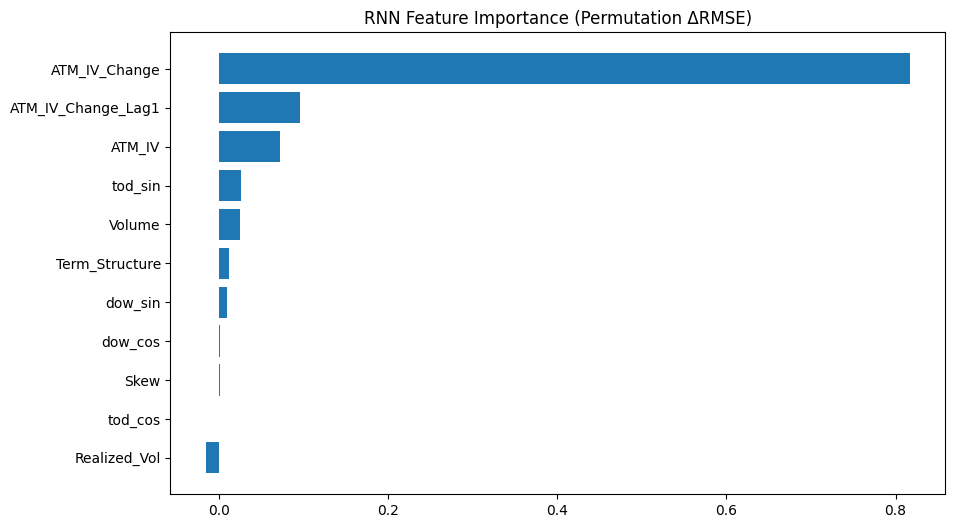


>>> Training Final CNN...



=== CNN RESULTS ===
Model RMSE:   6.694875
Baseline RMSE:8.980982
Improvement:  25.45%
Directional Accuracy: 63.71%


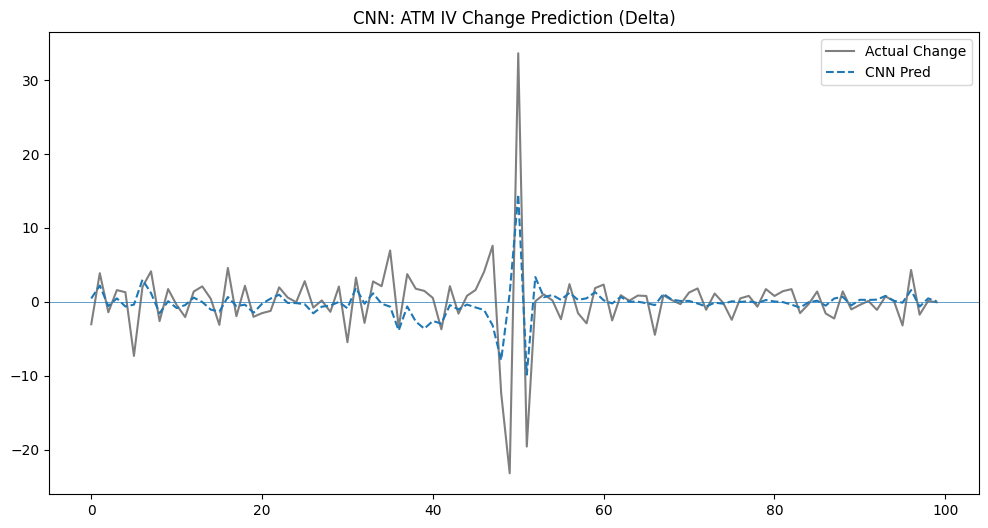

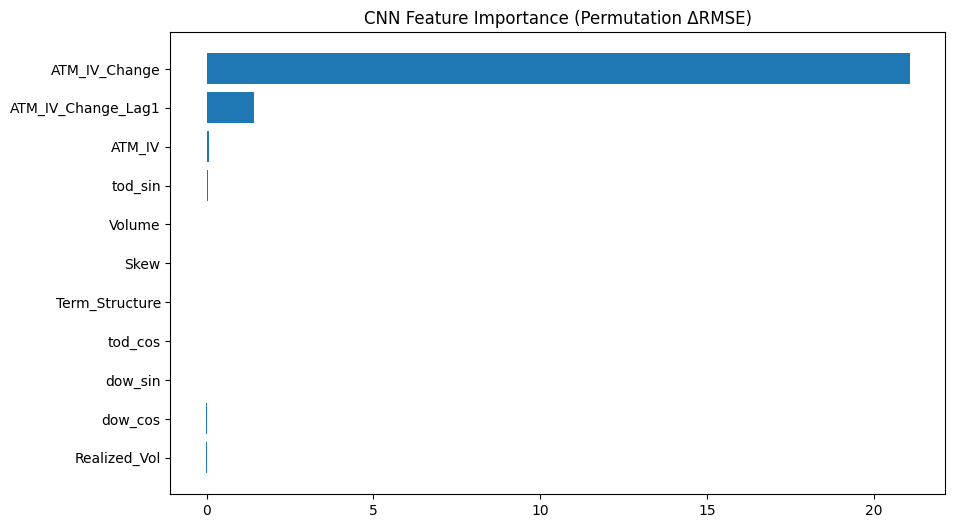


>>> Summary
RNN  RMSE=8.343048 | DirAcc=63.54%
CNN  RMSE=6.694875 | DirAcc=63.71%


In [4]:
import os, random
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ==========================================
# 0) CONFIG
# ==========================================
TIME_WINDOW = "15min"
FILE_PATH   = "../../data/derivative_data_2025.parquet"
N_TRIALS    = 20

SEQ_LEN     = 16
MAX_EPOCHS  = 30
PATIENCE    = 10
RANDOM_SEED = 11
# DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

VAL_FRAC    = 0.10  # val slice from end of training block

def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(RANDOM_SEED)

# ==========================================
# 1) DATA LOADING
# ==========================================
print(">>> Loading Parquet Data...")
df = pd.read_parquet(FILE_PATH, engine="pyarrow")

if pd.api.types.is_numeric_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df[df["instrument_name"].str.contains("BTC")]

split_names = df["instrument_name"].str.split("-", expand=True)
df["Expiry_Str"] = split_names[1]
df["Strike"]     = split_names[2].astype(float)
df["Type"]       = split_names[3]
df["Expiry"]     = pd.to_datetime(df["Expiry_Str"], format="%d%b%y", errors="coerce")

df["days_to_expiry"] = (df["Expiry"] - df["timestamp"]).dt.total_seconds() / (24 * 3600)
df["moneyness"]      = df["index_price"] / df["Strike"]
df["iv"]             = pd.to_numeric(df["iv"], errors="coerce")
df = df[df["iv"] > 0]

# ==========================================
# 2) FEATURE ENGINEERING (15-min bars)
# ==========================================
print(f">>> Resampling to {TIME_WINDOW} bars...")

def calculate_features(sub_df: pd.DataFrame):
    if sub_df.empty:
        return None
    stats = {}

    atm_mask = sub_df["moneyness"].between(0.98, 1.02)
    stats["ATM_IV"] = sub_df.loc[atm_mask, "iv"].mean() if atm_mask.any() else sub_df["iv"].mean()

    put_iv  = sub_df.loc[sub_df["Type"] == "P", "iv"].mean()
    call_iv = sub_df.loc[sub_df["Type"] == "C", "iv"].mean()
    put_iv  = put_iv  if pd.notna(put_iv)  else stats["ATM_IV"]
    call_iv = call_iv if pd.notna(call_iv) else stats["ATM_IV"]
    stats["Skew"] = put_iv - call_iv

    near_mask = sub_df["days_to_expiry"] <= 10
    far_mask  = sub_df["days_to_expiry"] > 10
    iv_near = sub_df.loc[near_mask, "iv"].mean()
    iv_far  = sub_df.loc[far_mask,  "iv"].mean()
    iv_near = iv_near if (pd.notna(iv_near) and iv_near > 0) else stats["ATM_IV"]
    iv_far  = iv_far  if pd.notna(iv_far) else stats["ATM_IV"]
    stats["Term_Structure"] = iv_far / iv_near

    stats["Close_Price"] = sub_df["index_price"].iloc[-1]
    stats["Volume"]      = sub_df["amount"].sum()
    return pd.Series(stats)

df_grouped = df.set_index("timestamp").resample(TIME_WINDOW).apply(calculate_features)
df_grouped = df_grouped.ffill()

# --- Option B: time-of-day + day-of-week cyclical encodings ---
ts = df_grouped.index
tod = ts.hour + ts.minute / 60.0
df_grouped["tod_sin"] = np.sin(2 * np.pi * tod / 24.0)
df_grouped["tod_cos"] = np.cos(2 * np.pi * tod / 24.0)

dow = ts.dayofweek.astype(float)  # 0..6
df_grouped["dow_sin"] = np.sin(2 * np.pi * dow / 7.0)
df_grouped["dow_cos"] = np.cos(2 * np.pi * dow / 7.0)

# ==========================================
# 3) TARGET CREATION (same as LGBM/CatBoost)
# ==========================================
print(">>> Creating Delta Target...")

df_grouped["ATM_IV_Change"]      = df_grouped["ATM_IV"].diff()
df_grouped["ATM_IV_Change_Lag1"] = df_grouped["ATM_IV_Change"].shift(1)

df_grouped["returns"]      = np.log(df_grouped["Close_Price"] / df_grouped["Close_Price"].shift(1))
df_grouped["Realized_Vol"] = df_grouped["returns"].shift(1).rolling(window=4).std()

df_grouped["Target_Delta"] = df_grouped["ATM_IV"].shift(-1) - df_grouped["ATM_IV"]

model_data = df_grouped.dropna()

feature_cols = [
    "ATM_IV","Skew","Term_Structure","Realized_Vol","Volume","ATM_IV_Change","ATM_IV_Change_Lag1",
    "tod_sin","tod_cos","dow_sin","dow_cos"
]

X = model_data[feature_cols]
y = model_data["Target_Delta"]

print(f"Data Prepared (tabular). Rows: {len(model_data)} | Features: {len(feature_cols)}")

# ==========================================
# 4) SEQUENCES
# ==========================================
def make_sequences(X_df: pd.DataFrame, y_s: pd.Series, seq_len: int):
    Xv = X_df.values.astype(np.float32)
    yv = y_s.values.astype(np.float32)

    X_seq, y_seq = [], []
    for t in range(seq_len - 1, len(Xv)):
        X_seq.append(Xv[t - seq_len + 1 : t + 1, :])
        y_seq.append(yv[t])
    return np.stack(X_seq), np.array(y_seq)

X_seq, y_seq = make_sequences(X, y, SEQ_LEN)
n_samples, _, n_features = X_seq.shape
print(f"NN Sequences: X={X_seq.shape}, y={y_seq.shape}")

# ==========================================
# 5) SPLIT (train/val/test chronological; no leakage)
# ==========================================
split_idx = int(n_samples * 0.8)  # test starts here
X_train_full, y_train_full = X_seq[:split_idx], y_seq[:split_idx]
X_test,       y_test       = X_seq[split_idx:], y_seq[split_idx:]

val_size  = max(1, int(len(X_train_full) * VAL_FRAC))
val_start = len(X_train_full) - val_size

X_train, y_train = X_train_full[:val_start], y_train_full[:val_start]
X_val,   y_val   = X_train_full[val_start:], y_train_full[val_start:]

print(f"NN Split: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

# ==========================================
# 6) TORCH HELPERS
# ==========================================
class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = torch.from_numpy(X_seq)                      # (N,T,F)
        self.y = torch.from_numpy(y_seq).unsqueeze(-1)        # (N,1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def fit_scaler_on_train(X_train_seq):
    scaler = StandardScaler()
    N, T, F = X_train_seq.shape
    scaler.fit(X_train_seq.reshape(N*T, F))
    return scaler

def apply_scaler(scaler, X_seq):
    N, T, F = X_seq.shape
    return scaler.transform(X_seq.reshape(N*T, F)).reshape(N, T, F).astype(np.float32)

def rmse_np(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

@torch.no_grad()
def predict_model(model, X_seq_np, batch_size=1024):
    model.eval()
    dl = DataLoader(SeqDataset(X_seq_np, np.zeros((len(X_seq_np),), dtype=np.float32)),
                    batch_size=batch_size, shuffle=False)
    preds = []
    for xb, _ in dl:
        xb = xb.to(DEVICE)
        preds.append(model(xb).detach().cpu().numpy().reshape(-1))
    return np.concatenate(preds)

def train_with_early_stopping(model, train_loader, val_loader, lr, weight_decay=0.0,
                              max_epochs=MAX_EPOCHS, patience=PATIENCE):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_rmse = np.inf
    best_state = None
    bad_epochs = 0

    # for _epoch in range(1, max_epochs + 1):
    for _epoch in tqdm(range(1, max_epochs + 1), desc="epochs", leave=False):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            opt.step()

        # val RMSE
        model.eval()
        vpred, vtrue = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                yhat = model(xb)
                vpred.append(yhat.detach().cpu().numpy().reshape(-1))
                vtrue.append(yb.detach().cpu().numpy().reshape(-1))
        vpred = np.concatenate(vpred); vtrue = np.concatenate(vtrue)
        val_rmse = rmse_np(vtrue, vpred)

        if val_rmse < best_rmse - 1e-8:
            best_rmse = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_rmse

# ==========================================
# 7) MODELS
# ==========================================
class RNNRegressor(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers, dropout, rnn_type="GRU"):
        super().__init__()
        rnn_cls = nn.GRU if rnn_type.upper() == "GRU" else nn.LSTM
        self.rnn = rnn_cls(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size, 1))
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.head(out[:, -1, :])

class CNN1DRegressor(nn.Module):
    def __init__(self, n_features, channels, kernel_size, dropout):
        super().__init__()
        padding = kernel_size // 2
        self.net = nn.Sequential(
            nn.Conv1d(n_features, channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Dropout(dropout), nn.Linear(channels, 1))
    def forward(self, x):
        x = x.transpose(1, 2)  # (N,F,T)
        return self.head(self.net(x))

# ==========================================
# 8) OPTUNA TUNING (CV only on train_full; test untouched)
# ==========================================
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("\n>>> Tuning RNN Hyperparameters...")

def objective_rnn(trial):
    seed_everything(RANDOM_SEED)

    rnn_type    = trial.suggest_categorical("rnn_type", ["GRU", "LSTM"])
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.0, 0.4)
    lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    wd          = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256])

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        X_tr, y_tr = X_train_full[tr_idx], y_train_full[tr_idx]
        X_va, y_va = X_train_full[va_idx], y_train_full[va_idx]

        scaler = fit_scaler_on_train(X_tr)
        X_tr_s = apply_scaler(scaler, X_tr)
        X_va_s = apply_scaler(scaler, X_va)

        train_loader = DataLoader(SeqDataset(X_tr_s, y_tr), batch_size=batch_size, shuffle=False)
        val_loader   = DataLoader(SeqDataset(X_va_s, y_va), batch_size=batch_size, shuffle=False)

        model = RNNRegressor(n_features, hidden_size, num_layers, dropout, rnn_type=rnn_type).to(DEVICE)
        scores.append(train_with_early_stopping(model, train_loader, val_loader, lr=lr, weight_decay=wd))

    return float(np.mean(scores))

study_rnn = optuna.create_study(direction="minimize")
study_rnn.optimize(objective_rnn, n_trials=N_TRIALS)
print(f"Best RNN Params: {study_rnn.best_params}")

print("\n>>> Tuning CNN Hyperparameters...")

def objective_cnn(trial):
    seed_everything(RANDOM_SEED)

    channels    = trial.suggest_int("channels", 16, 128)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    dropout     = trial.suggest_float("dropout", 0.0, 0.4)
    lr          = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    wd          = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256])

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        X_tr, y_tr = X_train_full[tr_idx], y_train_full[tr_idx]
        X_va, y_va = X_train_full[va_idx], y_train_full[va_idx]

        scaler = fit_scaler_on_train(X_tr)
        X_tr_s = apply_scaler(scaler, X_tr)
        X_va_s = apply_scaler(scaler, X_va)

        train_loader = DataLoader(SeqDataset(X_tr_s, y_tr), batch_size=batch_size, shuffle=False)
        val_loader   = DataLoader(SeqDataset(X_va_s, y_va), batch_size=batch_size, shuffle=False)

        model = CNN1DRegressor(n_features, channels, kernel_size, dropout).to(DEVICE)
        scores.append(train_with_early_stopping(model, train_loader, val_loader, lr=lr, weight_decay=wd))

    return float(np.mean(scores))

study_cnn = optuna.create_study(direction="minimize")
study_cnn.optimize(objective_cnn, n_trials=N_TRIALS)
print(f"Best CNN Params: {study_cnn.best_params}")

# ==========================================
# 9) PERMUTATION IMPORTANCE (NN analogue of "feature importance")
# ==========================================
def permutation_importance_seq(model, X_test_s, y_test, feature_names, batch_size=1024, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    base_pred = predict_model(model, X_test_s, batch_size=batch_size)
    base_rmse = rmse_np(y_test, base_pred)

    importances = []
    # for j, name in enumerate(feature_names):
    for j, name in tqdm(list(enumerate(feature_names)), desc="perm-imp", leave=False):
        Xp = X_test_s.copy()
        flat = Xp[:, :, j].reshape(-1)
        rng.shuffle(flat)
        Xp[:, :, j] = flat.reshape(Xp.shape[0], Xp.shape[1])
        pred_p = predict_model(model, Xp, batch_size=batch_size)
        rmse_p = rmse_np(y_test, pred_p)
        importances.append(rmse_p - base_rmse)  # increase in RMSE

    return base_rmse, np.array(importances, dtype=float)

def plot_feature_importance(importances, feature_names, title):
    idx = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(idx)), importances[idx], align="center")
    plt.yticks(range(len(idx)), np.array(feature_names)[idx])
    plt.title(title)
    plt.show()

# ==========================================
# 10) FINAL TRAINING & EVALUATION (no leakage)
# ==========================================
def evaluate_final(model_name, build_model, best_params):
    print(f"\n>>> Training Final {model_name}...")

    batch_size = int(best_params.get("batch_size", 128))
    lr = float(best_params["lr"])
    wd = float(best_params["weight_decay"])

    # scaler fit on TRAIN only
    scaler = fit_scaler_on_train(X_train)
    X_train_s = apply_scaler(scaler, X_train)
    X_val_s   = apply_scaler(scaler, X_val)
    X_test_s  = apply_scaler(scaler, X_test)

    train_loader = DataLoader(SeqDataset(X_train_s, y_train), batch_size=batch_size, shuffle=False)
    val_loader   = DataLoader(SeqDataset(X_val_s,   y_val),   batch_size=batch_size, shuffle=False)

    model = build_model().to(DEVICE)
    _ = train_with_early_stopping(model, train_loader, val_loader, lr=lr, weight_decay=wd)

    # test untouched until here
    y_pred = predict_model(model, X_test_s, batch_size=batch_size)

    final_rmse = rmse_np(y_test, y_pred)
    naive_rmse = rmse_np(y_test, np.zeros_like(y_test))

    pred_signs   = np.sign(y_pred)
    actual_signs = np.sign(y_test)
    valid_idx = actual_signs != 0
    dir_acc = accuracy_score(actual_signs[valid_idx], pred_signs[valid_idx])

    print(f"\n=== {model_name} RESULTS ===")
    print(f"Model RMSE:   {final_rmse:.6f}")
    print(f"Baseline RMSE:{naive_rmse:.6f}")
    print(f"Improvement:  {((naive_rmse - final_rmse)/naive_rmse)*100:.2f}%")
    print(f"Directional Accuracy: {dir_acc*100:.2f}%")

    # same output-style graph
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label="Actual Change", color="black", alpha=0.5)
    plt.plot(y_pred[:100], label=f"{model_name} Pred", linestyle="--")
    plt.axhline(0, lw=0.5)
    plt.title(f"{model_name}: ATM IV Change Prediction (Delta)")
    plt.legend()
    plt.show()

    # NN "feature importance" analogue
    _, imps = permutation_importance_seq(model, X_test_s, y_test, feature_cols, batch_size=batch_size)
    plot_feature_importance(imps, feature_cols, title=f"{model_name} Feature Importance (Permutation ΔRMSE)")

    return final_rmse, dir_acc

# ---- Final RNN ----
bestRNN = study_rnn.best_params
def make_final_rnn():
    return RNNRegressor(
        n_features=n_features,
        hidden_size=int(bestRNN["hidden_size"]),
        num_layers=int(bestRNN["num_layers"]),
        dropout=float(bestRNN["dropout"]),
        rnn_type=str(bestRNN["rnn_type"])
    )

rmse_rnn, dir_rnn = evaluate_final("RNN", make_final_rnn, bestRNN)

# ---- Final CNN ----
bestCNN = study_cnn.best_params
def make_final_cnn():
    return CNN1DRegressor(
        n_features=n_features,
        channels=int(bestCNN["channels"]),
        kernel_size=int(bestCNN["kernel_size"]),
        dropout=float(bestCNN["dropout"])
    )

rmse_cnn, dir_cnn = evaluate_final("CNN", make_final_cnn, bestCNN)

print("\n>>> Summary")
print(f"RNN  RMSE={rmse_rnn:.6f} | DirAcc={dir_rnn*100:.2f}%")
print(f"CNN  RMSE={rmse_cnn:.6f} | DirAcc={dir_cnn*100:.2f}%")


# Summary 

### Time features
Adds cyclical time-of-day and day-of-week encodings to capture intraday/weekly patterns.
Examples: tod_sin/tod_cos, dow_sin/dow_cos.

### Target construction
Defines the prediction target as the next 15-minute change in ATM implied volatility.
Example: Target_Delta = ATM_IV(t+1) − ATM_IV(t) and adds lag/realized-vol helpers.

### Sequence building
Turns the tabular time series into fixed-length sequences so the model sees recent history.
Example: each sample uses the last 16 bars of features to predict the current Target_Delta.

### Models
Trains two neural regressors to predict a single real-valued delta.
Examples: RNN (GRU/LSTM reads sequence), CNN1D (Conv1d over time + pooling).

### Training + tuning
Uses Optuna to search hyperparameters with time-series cross-validation and early stopping.
Examples: tunes hidden_size/layers for RNN, channels/kernel_size for CNN; stops after PATIENCE bad val epochs.

### Evaluation + diagnostics
Evaluates on untouched test: RMSE vs zero-change baseline, plus directional accuracy (sign match).
Examples: plots first 100 test points; permutation importance shuffles one feature (e.g., ATM_IV) and measures RMSE increase.

In [5]:
import os, random
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ==========================================
# 0) CONFIG
# ==========================================
TIME_WINDOW = "15min"
FILE_PATH   = "../../data/derivative_data_2025.parquet"
N_TRIALS    = 20

SEQ_LEN     = 16
MAX_EPOCHS  = 30
PATIENCE    = 10
RANDOM_SEED = 11
# DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

VAL_FRAC    = 0.10  # val slice from end of training block

def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(RANDOM_SEED)

# ==========================================
# 1) DATA LOADING
# ==========================================
print(">>> Loading Parquet Data...")
df = pd.read_parquet(FILE_PATH, engine="pyarrow")

if pd.api.types.is_numeric_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df[df["instrument_name"].str.contains("BTC")]

split_names = df["instrument_name"].str.split("-", expand=True)
df["Expiry_Str"] = split_names[1]
df["Strike"]     = split_names[2].astype(float)
df["Type"]       = split_names[3]
df["Expiry"]     = pd.to_datetime(df["Expiry_Str"], format="%d%b%y", errors="coerce")

df["days_to_expiry"] = (df["Expiry"] - df["timestamp"]).dt.total_seconds() / (24 * 3600)
df["moneyness"]      = df["index_price"] / df["Strike"]
df["iv"]             = pd.to_numeric(df["iv"], errors="coerce")
df = df[df["iv"] > 0]

# ==========================================
# 2) FEATURE ENGINEERING (15-min bars)
# ==========================================
print(f">>> Resampling to {TIME_WINDOW} bars...")

def calculate_features(sub_df: pd.DataFrame):
    if sub_df.empty:
        return None
    stats = {}

    atm_mask = sub_df["moneyness"].between(0.98, 1.02)
    stats["ATM_IV"] = sub_df.loc[atm_mask, "iv"].mean() if atm_mask.any() else sub_df["iv"].mean()

    put_iv  = sub_df.loc[sub_df["Type"] == "P", "iv"].mean()
    call_iv = sub_df.loc[sub_df["Type"] == "C", "iv"].mean()
    put_iv  = put_iv  if pd.notna(put_iv)  else stats["ATM_IV"]
    call_iv = call_iv if pd.notna(call_iv) else stats["ATM_IV"]
    stats["Skew"] = put_iv - call_iv

    near_mask = sub_df["days_to_expiry"] <= 10
    far_mask  = sub_df["days_to_expiry"] > 10
    iv_near = sub_df.loc[near_mask, "iv"].mean()
    iv_far  = sub_df.loc[far_mask,  "iv"].mean()
    iv_near = iv_near if (pd.notna(iv_near) and iv_near > 0) else stats["ATM_IV"]
    iv_far  = iv_far  if pd.notna(iv_far) else stats["ATM_IV"]
    stats["Term_Structure"] = iv_far / iv_near

    stats["Close_Price"] = sub_df["index_price"].iloc[-1]
    stats["Volume"]      = sub_df["amount"].sum()
    return pd.Series(stats)

df_grouped = df.set_index("timestamp").resample(TIME_WINDOW).apply(calculate_features)
df_grouped = df_grouped.ffill()

# --- Option B: time-of-day + day-of-week cyclical encodings ---
ts = df_grouped.index
tod = ts.hour + ts.minute / 60.0
df_grouped["tod_sin"] = np.sin(2 * np.pi * tod / 24.0)
df_grouped["tod_cos"] = np.cos(2 * np.pi * tod / 24.0)

dow = ts.dayofweek.astype(float)  # 0..6
df_grouped["dow_sin"] = np.sin(2 * np.pi * dow / 7.0)
df_grouped["dow_cos"] = np.cos(2 * np.pi * dow / 7.0)

# ==========================================
# 3) TARGET CREATION (same as LGBM/CatBoost)
# ==========================================
print(">>> Creating Delta Target...")

df_grouped["ATM_IV_Change"]      = df_grouped["ATM_IV"].diff()
df_grouped["ATM_IV_Change_Lag1"] = df_grouped["ATM_IV_Change"].shift(1)

df_grouped["returns"]      = np.log(df_grouped["Close_Price"] / df_grouped["Close_Price"].shift(1))
df_grouped["Realized_Vol"] = df_grouped["returns"].shift(1).rolling(window=4).std()

df_grouped["Target_Delta"] = df_grouped["ATM_IV"].shift(-1) - df_grouped["ATM_IV"]

model_data = df_grouped.dropna()

feature_cols = [
    "ATM_IV","Skew","Term_Structure","Realized_Vol","Volume","ATM_IV_Change","ATM_IV_Change_Lag1",
    "tod_sin","tod_cos","dow_sin","dow_cos"
]

X = model_data[feature_cols]
y = model_data["Target_Delta"]

print(f"Data Prepared (tabular). Rows: {len(model_data)} | Features: {len(feature_cols)}")

# ==========================================
# 4) SEQUENCES
# ==========================================
def make_sequences(X_df: pd.DataFrame, y_s: pd.Series, seq_len: int):
    Xv = X_df.values.astype(np.float32)
    yv = y_s.values.astype(np.float32)

    X_seq, y_seq = [], []
    for t in range(seq_len - 1, len(Xv)):
        X_seq.append(Xv[t - seq_len + 1 : t + 1, :])
        y_seq.append(yv[t])
    return np.stack(X_seq), np.array(y_seq)

X_seq, y_seq = make_sequences(X, y, SEQ_LEN)
n_samples, _, n_features = X_seq.shape
print(f"NN Sequences: X={X_seq.shape}, y={y_seq.shape}")

# ==========================================
# 5) SPLIT (train/val/test chronological; no leakage)
# ==========================================
split_idx = int(n_samples * 0.8)  # test starts here
X_train_full, y_train_full = X_seq[:split_idx], y_seq[:split_idx]
X_test,       y_test       = X_seq[split_idx:], y_seq[split_idx:]

val_size  = max(1, int(len(X_train_full) * VAL_FRAC))
val_start = len(X_train_full) - val_size

X_train, y_train = X_train_full[:val_start], y_train_full[:val_start]
X_val,   y_val   = X_train_full[val_start:], y_train_full[val_start:]

print(f"NN Split: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")


>>> Loading Parquet Data...
>>> Resampling to 15min bars...
>>> Creating Delta Target...
Data Prepared (tabular). Rows: 35130 | Features: 11
NN Sequences: X=(35115, 16, 11), y=(35115,)
NN Split: train=25283, val=2809, test=7023


DEVICE: mps


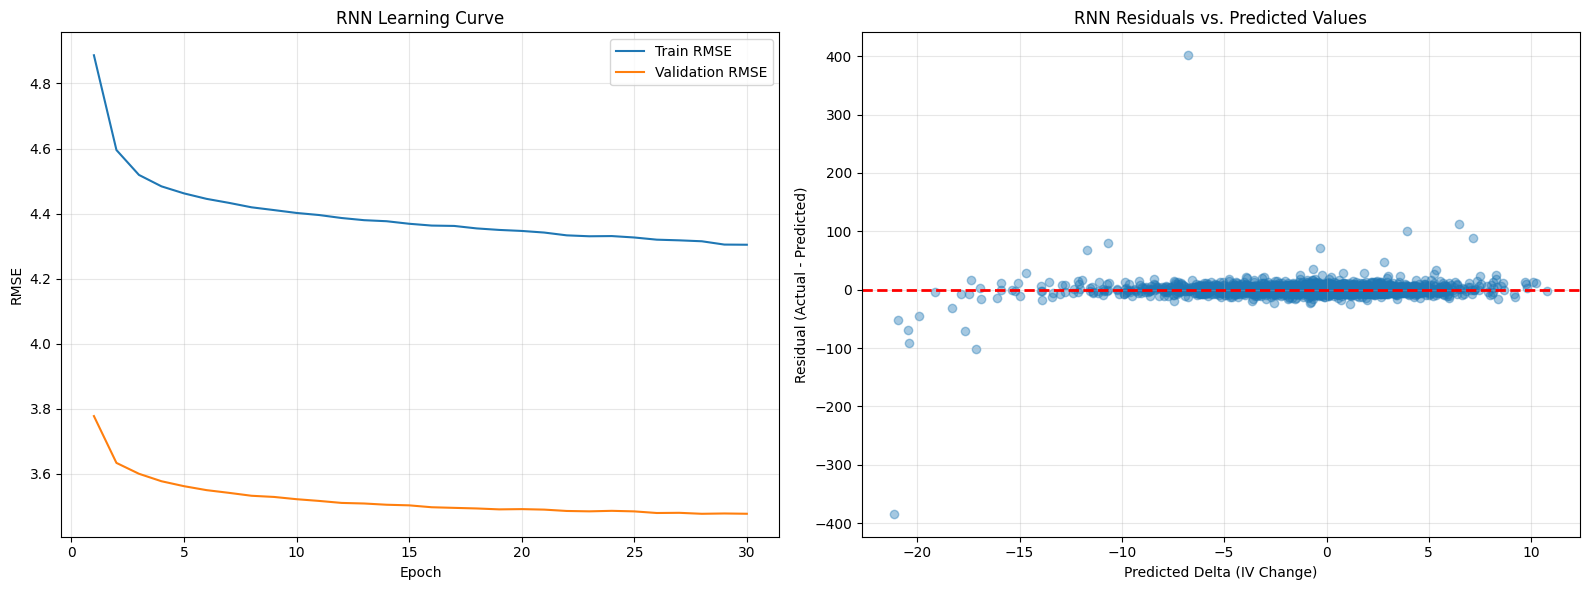

RNN | last train RMSE=4.303987 | last val RMSE=3.476499 | test RMSE=8.408758


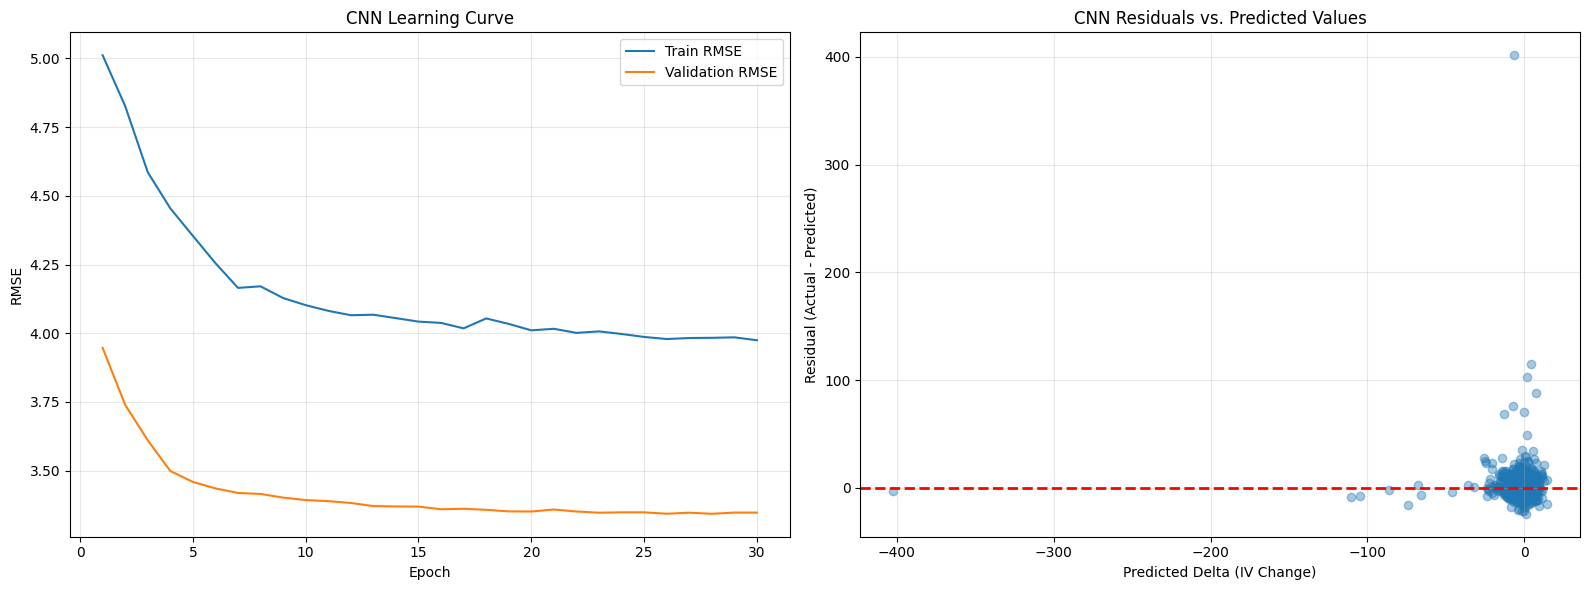

CNN | last train RMSE=3.974569 | last val RMSE=3.347771 | test RMSE=6.719631


In [6]:
# ==========================================
# DIAGNOSTICS: RNN + CNN (Learning curve + Residuals vs Pred)
# SELF-CONTAINED: does NOT rely on anything from your earlier cell.
# Only requirement: your data arrays exist in memory:
#   X_train, y_train, X_val, y_val, X_test, y_test
# where X_* is (N,T,F) float and y_* is (N,) or (N,1) float.
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ---- set device (same logic you used) ----
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ---- hyperparams for quick final fitting (edit if needed) ----
MAX_EPOCHS = 30
PATIENCE  = 10

# ---- manual best params (your printed output) ----
bestRNN = {
    "rnn_type": "LSTM",
    "hidden_size": 124,
    "num_layers": 2,
    "dropout": 0.08970216565433058,
    "lr": 0.00044078917629833576,
    "weight_decay": 0.006949732456304038,
    "batch_size": 256
}
bestCNN = {
    "channels": 48,
    "kernel_size": 7,
    "dropout": 0.3051715051170321,
    "lr": 0.0009867502969472112,
    "weight_decay": 0.0052445339345040315,
    "batch_size": 256
}

# ==========================================
# Helpers
# ==========================================
class SeqDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        X_seq = np.asarray(X_seq, dtype=np.float32)
        y_seq = np.asarray(y_seq, dtype=np.float32).reshape(-1)
        self.X = torch.from_numpy(X_seq)                 # (N,T,F)
        self.y = torch.from_numpy(y_seq).unsqueeze(-1)   # (N,1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def fit_scaler_on_train(X_train_seq):
    X_train_seq = np.asarray(X_train_seq, dtype=np.float32)
    N, T, F = X_train_seq.shape
    scaler = StandardScaler()
    scaler.fit(X_train_seq.reshape(N*T, F))
    return scaler

def apply_scaler(scaler, X_seq):
    X_seq = np.asarray(X_seq, dtype=np.float32)
    N, T, F = X_seq.shape
    Xs = scaler.transform(X_seq.reshape(N*T, F)).reshape(N, T, F)
    return Xs.astype(np.float32)

@torch.no_grad()
def predict_model(model, X_seq_np, batch_size=1024):
    model.eval()
    dl = DataLoader(SeqDataset(X_seq_np, np.zeros((len(X_seq_np),), dtype=np.float32)),
                    batch_size=batch_size, shuffle=False)
    out = []
    for xb, _ in dl:
        xb = xb.to(DEVICE)
        out.append(model(xb).detach().cpu().numpy().reshape(-1))
    return np.concatenate(out)

def train_with_history(model, train_loader, val_loader, lr, weight_decay=0.0,
                       max_epochs=MAX_EPOCHS, patience=PATIENCE):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_rmse = np.inf
    best_state = None
    bad = 0

    train_hist, val_hist = [], []

    for _epoch in range(1, max_epochs + 1):
        # ---- train ----
        model.train()
        tr_pred, tr_true = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            opt.step()
            tr_pred.append(yhat.detach().cpu().numpy().reshape(-1))
            tr_true.append(yb.detach().cpu().numpy().reshape(-1))
        tr_rmse = rmse_np(np.concatenate(tr_true), np.concatenate(tr_pred))

        # ---- val ----
        model.eval()
        va_pred, va_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                yhat = model(xb)
                va_pred.append(yhat.detach().cpu().numpy().reshape(-1))
                va_true.append(yb.detach().cpu().numpy().reshape(-1))
        va_rmse = rmse_np(np.concatenate(va_true), np.concatenate(va_pred))

        train_hist.append(tr_rmse)
        val_hist.append(va_rmse)

        # ---- early stop ----
        if va_rmse < best_rmse - 1e-8:
            best_rmse = va_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_hist, val_hist

def plot_two_graphs(model_name, train_hist, val_hist, y_test, y_pred):
    y_test = np.asarray(y_test).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    residuals = y_test - y_pred

    x_axis = range(1, len(train_hist) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # learning curve
    axes[0].plot(x_axis, train_hist, label="Train RMSE")
    axes[0].plot(x_axis, val_hist, label="Validation RMSE")
    axes[0].set_title(f"{model_name} Learning Curve")
    axes[0].set_ylabel("RMSE")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # residuals vs predictions
    axes[1].scatter(y_pred, residuals, alpha=0.4)
    axes[1].axhline(0, color="red", linestyle="--", lw=2)
    axes[1].set_title(f"{model_name} Residuals vs. Predicted Values")
    axes[1].set_xlabel("Predicted Delta (IV Change)")
    axes[1].set_ylabel("Residual (Actual - Predicted)")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# Models
# ==========================================
class RNNRegressor(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers, dropout, rnn_type="GRU"):
        super().__init__()
        rnn_cls = nn.LSTM if str(rnn_type).upper() == "LSTM" else nn.GRU
        self.rnn = rnn_cls(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden_size, 1))
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.head(out[:, -1, :])

class CNN1DRegressor(nn.Module):
    def __init__(self, n_features, channels, kernel_size, dropout):
        super().__init__()
        padding = int(kernel_size) // 2
        self.net = nn.Sequential(
            nn.Conv1d(n_features, channels, int(kernel_size), padding=padding),
            nn.ReLU(),
            nn.Conv1d(channels, channels, int(kernel_size), padding=padding),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Dropout(float(dropout)), nn.Linear(channels, 1))
    def forward(self, x):
        x = x.transpose(1, 2)  # (N,F,T)
        return self.head(self.net(x))

# ==========================================
# Run diagnostics for each model (will retrain once to collect history)
# ==========================================
def run_diagnostics(model_name, build_model, params):
    # infer feature count from your data
    n_features = int(np.asarray(X_train).shape[2])

    # scale based on TRAIN only
    scaler = fit_scaler_on_train(X_train)
    Xtr = apply_scaler(scaler, X_train)
    Xva = apply_scaler(scaler, X_val)
    Xte = apply_scaler(scaler, X_test)

    bs = int(params["batch_size"])
    lr = float(params["lr"])
    wd = float(params["weight_decay"])

    train_loader = DataLoader(SeqDataset(Xtr, y_train), batch_size=bs, shuffle=False)
    val_loader   = DataLoader(SeqDataset(Xva, y_val),   batch_size=bs, shuffle=False)

    model = build_model(n_features).to(DEVICE)

    train_hist, val_hist = train_with_history(
        model, train_loader, val_loader, lr=lr, weight_decay=wd,
        max_epochs=MAX_EPOCHS, patience=PATIENCE
    )

    y_pred = predict_model(model, Xte, batch_size=bs)
    plot_two_graphs(model_name, train_hist, val_hist, y_test, y_pred)

    print(f"{model_name} | last train RMSE={train_hist[-1]:.6f} | last val RMSE={val_hist[-1]:.6f} | test RMSE={rmse_np(y_test, y_pred):.6f}")

# ---- RNN diagnostics ----
def build_rnn(n_features):
    return RNNRegressor(
        n_features=n_features,
        hidden_size=int(bestRNN["hidden_size"]),
        num_layers=int(bestRNN["num_layers"]),
        dropout=float(bestRNN["dropout"]),
        rnn_type=str(bestRNN["rnn_type"]),
    )

run_diagnostics("RNN", build_rnn, bestRNN)

# ---- CNN diagnostics ----
def build_cnn(n_features):
    return CNN1DRegressor(
        n_features=n_features,
        channels=int(bestCNN["channels"]),
        kernel_size=int(bestCNN["kernel_size"]),
        dropout=float(bestCNN["dropout"]),
    )

run_diagnostics("CNN", build_cnn, bestCNN)
